# Evaluation of the Random Forest approach for our binary classification task.
TODO Resume what is done overall in the notebook

## Main Logic (Functions we will call later)

In [1]:
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score


In [3]:
# =============================================================================
# STEP 1+2 CORRETTO: Load data, split PRIMA, poi vettorizza
# =============================================================================
import sys
sys.path.append("../source")
from src import stratified_split, truncated_svd

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 1. Load cleaned text data
df_supervised = pd.read_csv("./clean_supervised.csv")
df_supervised = df_supervised.dropna(subset=['body_clean'])

# 2. Group by author
df_grouped = df_supervised.groupby('author')['body_clean'].apply(" ".join).reset_index()
df_grouped = df_grouped.rename(columns={'body_clean': 'body'})

# 3. Load and match labels
target_df = pd.read_csv("./Data/target_supervised.csv")
labels = []
for auth in df_grouped['author']:
    match = target_df[target_df['author'] == auth]
    if not match.empty:
        labels.append(match['gender'].iloc[0])
    else:
        labels.append(None)

df_grouped['label'] = labels
df_grouped = df_grouped.dropna(subset=['label'])
print(f"Dataset size: {len(df_grouped)} authors")

# 4. SPLIT PRIMA della vettorizzazione! (questo evita data leakage)
X_text = df_grouped['body'].values
y = df_grouped['label'].values

X_text_train, X_text_val, X_text_test, y_train, y_val, y_test = stratified_split(X_text, y)
print(f"Train: {len(X_text_train)}, Val: {len(X_text_val)}, Test: {len(X_text_test)}")

# 5. BoW - fit SOLO su train
bow_vectorizer = CountVectorizer(min_df=5, max_df=0.99)
X_bow_train = bow_vectorizer.fit_transform(X_text_train)
X_bow_val = bow_vectorizer.transform(X_text_val)
X_bow_test = bow_vectorizer.transform(X_text_test)
print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# 6. TF-IDF - fit SOLO su train
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.99)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_val = tfidf_vectorizer.transform(X_text_val)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# 7. SVD - fit SOLO su train
X_bowsvd_train, X_bowsvd_val, X_bowsvd_test = truncated_svd(X_bow_train, X_bow_val, X_bow_test)
X_tfidfsvd_train, X_tfidfsvd_val, X_tfidfsvd_test = truncated_svd(X_tfidf_train, X_tfidf_val, X_tfidf_test)

y_bowsvd_train = y_train
y_bowsvd_val = y_val
y_bowsvd_test = y_test
y_tfidfsvd_train = y_train
y_tfidfsvd_val = y_val
y_tfidfsvd_test = y_test

print("\n✅ Dati pronti per il Random Forest!")

Dataset size: 4942 authors
Train: 3952, Val: 495, Test: 495
BoW vocabulary size: 21207
TF-IDF vocabulary size: 21207

✅ Dati pronti per il Random Forest!


In [4]:
#Train and evaluate a Random Forest model on X,Y
def RF_train_eval(X_train, y_train, X_test, y_test):
    randomforest = RandomForestClassifier()
    randomforest.fit(X_train,y_train)
    y_train_pred = randomforest.predict(X_train)
    y_test_pred = randomforest.predict(X_test)

    print("Performance on Training data")
    print(classification_report(y_train,y_train_pred))

    print("results on the testing data")
    print(classification_report(y_test, y_test_pred))

    # get the confusion matrix of test set
    confusion_test = confusion_matrix(y_test, y_test_pred)

    # visualize the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

### Test correct behaviour 
Let's try on data from one of the four possible pre processing pipelines for now and we will try on the others afterwards.
Testing on bow representation filtered through quantiles.

Performance on Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2888
           1       1.00      1.00      1.00      1064

    accuracy                           1.00      3952
   macro avg       1.00      1.00      1.00      3952
weighted avg       1.00      1.00      1.00      3952

results on the testing data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       362
           1       1.00      0.14      0.25       133

    accuracy                           0.77       495
   macro avg       0.88      0.57      0.56       495
weighted avg       0.82      0.77      0.70       495



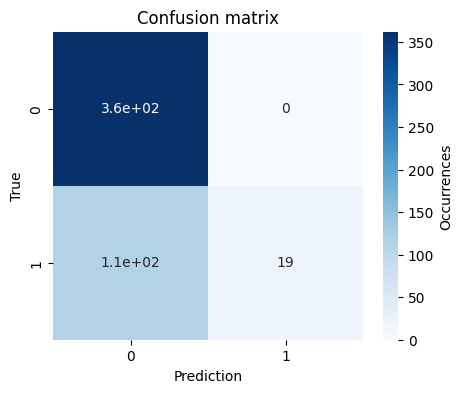

Performance on Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2888
           1       1.00      1.00      1.00      1064

    accuracy                           1.00      3952
   macro avg       1.00      1.00      1.00      3952
weighted avg       1.00      1.00      1.00      3952

results on the testing data
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       362
           1       1.00      0.14      0.24       133

    accuracy                           0.77       495
   macro avg       0.88      0.57      0.55       495
weighted avg       0.82      0.77      0.70       495



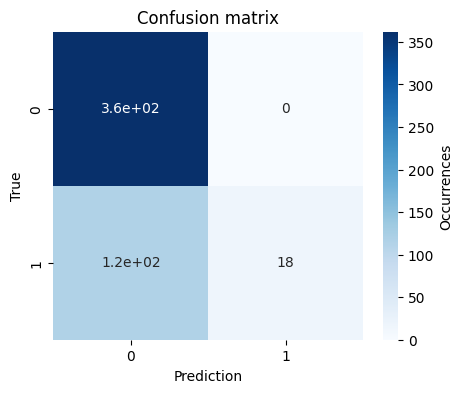

In [5]:
#Create Random Forest model and print results
RF_train_eval(X_bow_train, y_train, X_bow_test, y_test)
RF_train_eval(X_tfidf_train, y_train, X_tfidf_test, y_test)

Con BoW: Recall di 1.00 per la classe 0 (male) e 0.14 per la classe 1 (female) sul test set, con accuracy complessiva di 0.77.
Con TF-IDF: Recall di 1.00 per la classe 0 e 0.14 per la classe 1 sul test set, con accuracy complessiva di 0.77.

Chiaramente lo sbilanciamento delle classi fa sì che il modello favorisca la predizione della classe maggioritaria (male), causando un recall molto basso sulla classe 1 e una macro avg di circa 0.56-0.57, che non è ideale.

Prima di procedere con Grid Search per ottimizzare gli iperparametri del Random Forest, testiamo quale pipeline di preprocessing funziona meglio.

### Overview of results
In termini di accuracy complessiva, i risultati sul test set con Random Forest default sono:
1. 0.77 usando BoW (X_bow)
2. 0.77 usando TF-IDF (X_tfidf)

Considerando che il dataset è sbilanciato e vogliamo predire anche la classe minoritaria (female), la metrica più interessante è la macro avg recall:
1. ~0.57 per BoW
2. ~0.57 per TF-IDF

Entrambe le rappresentazioni mostrano performance simili con i parametri di default. Il recall sulla classe 1 è solo 0.14 in entrambi i casi, indicando che il modello predice quasi sempre la classe maggioritaria.

Procediamo con la rappresentazione BoW per la selezione degli iperparametri tramite Grid Search, utilizzando anche `class_weight='balanced'` per gestire lo sbilanciamento.

## Hyper parameter selection through Grid Search

In [6]:
'''
RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,
      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,
        warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
'''

"\nRandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, \n    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,\n      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0,\n        warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)\n"

In [7]:
# n_estimators - number of Decision trees in the random forest.
estimators = [80,100,120,140]
#min_samples_leaf minimal number
min_samples_leaf = [1,2,3,4]
#function
criterion = ["gini", "entropy", "log_loss"]
#The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss”
#and “entropy” both for the Shannon information gain, see Mathematical formulation.

max_depth = [5,10,20,None] #None is a valid option, corresponds to infinite (no max).
#Max depth for the trees.

In [8]:
X_train = X_bow_train
Y_train = y_train 
X_val = X_bow_val
Y_val = y_val
X_test = X_bow_test
Y_test = y_test


best_parameters = [60,1,"gini",1]
best_balanced_accuracy_score = 0
best_val_pred = None
best_test_pred = None

for est in estimators:
    for min_sam in  min_samples_leaf:
        for crit in criterion:
            for max in max_depth:
                print(f"estimators: {est}, min_samples_leaf: {min_sam}, criterion: {crit}, max: {max}")
                randomforest = RandomForestClassifier(random_state=40,n_estimators=est,min_samples_leaf=min_sam,criterion=crit,max_depth=max,class_weight='balanced')
                randomforest.fit(X_train,Y_train)
                y_val_pred = randomforest.predict(X_val)
                y_test_pred = randomforest.predict(X_test)

                print(accuracy_score(Y_val,y_val_pred))
                print(balanced_accuracy_score(Y_val, y_val_pred))
                if balanced_accuracy_score(Y_val, y_val_pred) > best_balanced_accuracy_score:
                    best_balanced_accuracy_score = balanced_accuracy_score(Y_val, y_val_pred)
                    best_parameters = [est,min_sam,crit,max]
                    best_val_pred = y_val_pred
                    best_test_pred = y_test_pred
                print("\n")

estimators: 80, min_samples_leaf: 1, criterion: gini, max: 5
0.8202020202020202
0.7224899264736426


estimators: 80, min_samples_leaf: 1, criterion: gini, max: 10
0.8242424242424242
0.7252523574128692


estimators: 80, min_samples_leaf: 1, criterion: gini, max: 20
0.7797979797979798
0.6473019565488306


estimators: 80, min_samples_leaf: 1, criterion: gini, max: None
0.7656565656565657
0.5710443235159722


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 5
0.8161616161616162
0.7197274955344162


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 10
0.8181818181818182
0.7234868940306567


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: 20
0.795959595959596
0.6702425954388734


estimators: 80, min_samples_leaf: 1, criterion: entropy, max: None
0.7818181818181819
0.601119511485897


estimators: 80, min_samples_leaf: 1, criterion: log_loss, max: 5
0.8161616161616162
0.7197274955344162


estimators: 80, min_samples_leaf: 1, criterion: log_loss, max: 10
0

[100, 4, 'entropy', 10]
Best Marco avg Recall on validation set: 0.7545590495575956
results on the validation data
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       362
           1       0.74      0.59      0.65       133

    accuracy                           0.83       495
   macro avg       0.80      0.75      0.77       495
weighted avg       0.83      0.83      0.83       495

results on the test data
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       362
           1       0.75      0.59      0.66       133

    accuracy                           0.84       495
   macro avg       0.81      0.76      0.78       495
weighted avg       0.83      0.84      0.83       495



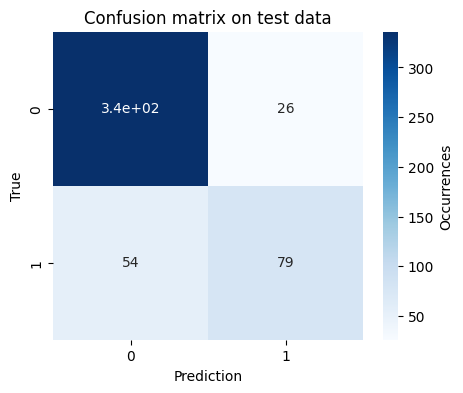

In [9]:
print(best_parameters)
print(f"Best Marco avg Recall on validation set: {best_balanced_accuracy_score}")

print("results on the validation data")
print(classification_report(Y_val, best_val_pred))

print("results on the test data")
print(classification_report(Y_test, best_test_pred))

# get the confusion matrix of test set
confusion_test = confusion_matrix(Y_test, best_test_pred)

# visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix on test data')
plt.show()

Come possiamo vedere, con gli iperparametri ottimizzati [100, 4, 'entropy', 10] e `class_weight='balanced'`, raggiungiamo:
- **Validation set**: accuracy 0.83, macro avg recall 0.75
- **Test set**: accuracy 0.84, macro avg recall 0.76

La classe 1 (female) ora ha un recall di 0.59 (rispetto a 0.14 con parametri default), un miglioramento significativo. L'uso di `class_weight='balanced'` ha aiutato a gestire lo sbilanciamento delle classi. La piccola differenza tra validation e test set indica che non c'è overfitting significativo.